# Building Good Training Datasets – Data Preprocessing


### Overview
- Dealing with missing data
    - Identifying missing values in tabular data
    - Eliminating training examples or features with missing values
    - Imputing missing values
    - Understanding the scikit-learn estimator API

- Handling categorical data
    - Nominal and ordinal features
    - Mapping ordinal features
    - Encoding class labels
    - Performing one-hot encoding on nominal features

- Partitioning a dataset into a separate training and test set
- Bringing features onto the same scale
- Selecting meaningful features
    - L1 and L2 regularization as penalties against model complexity
    - A geometric interpretation of L2 regularization
    - Sparse solutions with L1 regularization
    - Sequential feature selection algorithms

- Assessing feature importance with Random Forests
- Summary

In [1]:
from IPython.display import Image
%matplotlib inline

## Dealing with missing data

It is not uncommon in real-world applications for our training examples to be missing one or more values for various reasons. There could have been an error in the data collection process, certain measurements may not be applicable, or particular fields could have been simply left blank in a survey, for
example. We typically see missing values as blank spaces in our data table or as placeholder strings such as `NaN`, which stands for `“not a number,”` or `NULL` (a commonly used indicator of unknown values in relational databases). Unfortunately, most computational tools are unable to handle such missing
values or will produce unpredictable results if we simply ignore them. Therefore, it is crucial that we take care of those missing values before we proceed with further analyses.


### Identifying missing values in tabular data

In tabular data, missing values are often represented as `NaN` (Not a Number) or `NULL`. In Python, the `pandas` library provides tools to identify and handle these missing values effectively.

In [2]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with missing values
data = {
    'Feature1': [1, 2, np.nan, 4],
    'Feature2': [np.nan, 1, 2, 3],
    'Feature3': [1, 2, 3, 4]
}
df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)


# Identify missing values
missing_values = df.isnull()
print("\nMissing Values:")
print(missing_values)

Original DataFrame:
   Feature1  Feature2  Feature3
0       1.0       NaN         1
1       2.0       1.0         2
2       NaN       2.0         3
3       4.0       3.0         4

Missing Values:
   Feature1  Feature2  Feature3
0     False      True     False
1     False     False     False
2      True     False     False
3     False     False     False


In [3]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


For a larger DataFrame, it can be tedious to look for missing values manually; in this case, we can use the isnull method to return a DataFrame with Boolean values that indicate whether a cell contains a numeric value (False) or if data is missing (True). Using the sum method, we can then return the
number of missing values per column as follows:

In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### Eliminating training examples or features with missing values
Sometimes, it may be reasonable to simply remove training examples or features that contain missing values. This is especially true if only a small fraction of the data is missing. In `pandas`, we can use the `dropna` method to eliminate training examples (rows) or features (columns) with missing values. By default, the `dropna` method removes any row that contains at least one missing value. However, we can change this behavior by specifying the `axis` parameter. For example, to remove any feature (column) that contains at least one missing value, we can set `axis=1` as follows:


In [6]:
df_cleaned = df.dropna(axis=1)
df_cleaned

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


- rows with missing values removed

In [8]:
df_cleaned = df.dropna(axis=0)
df_cleaned

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
# only drop rows where all columns are NaN

df_cleaned = df.dropna(how='all')
df_cleaned

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [10]:
# drop rows that have fewer than 3 real values 

df_cleaned = df.dropna(thresh=4)
df_cleaned

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
# only drop rows where NaN appear in specific columns (here: 'C')

df_cleaned = df.dropna(subset=['C'])
df_cleaned

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


Although the removal of missing data seems to be a convenient approach, it also comes with certain disadvantages; for example, we may end up removing too many samples, which will make a reliable analysis impossible. Or, if we remove too many feature columns, we will run the risk of losing valuable
information that our classifier needs to discriminate between classes.

### Imputing missing values
When we have to deal with a significant amount of missing data, removing training examples or features may not be a viable option. In such cases, we can use various imputation techniques to fill in the missing values. Common strategies include replacing missing values with the mean, median, or mode of the respective feature column. More advanced methods involve using algorithms like k-nearest neighbors (KNN) or regression models to predict and fill in the missing values based on other available data.

In [ ]:
# again: our original array
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

One of the most common interpolation techniques is `mean imputation`, where we simply replace the missing value with the mean value of the entire feature column. A convenient way to achieve this is by using the `SimpleImputer` class from `scikit-learn`.

In [13]:
# impute missing values via the column mean
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [14]:
df_cleaned = df.fillna(df.mean())
df_cleaned

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [15]:
# Additional imputation methods for missing data, using the KNNImputer from scikit-learn
from sklearn.impute import KNNImputer
import numpy as np
imr = KNNImputer(n_neighbors=2)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

### Understanding the scikit-learn estimator API

The `scikit-learn` library provides a consistent and user-friendly interface for various machine learning algorithms and data preprocessing techniques. This interface is known as the `estimator API`. The key components of the estimator API include:
- **Estimator**: An object that implements the `fit` method to learn from data. Examples include classifiers, regressors, and transformers.
- **Transformer**: An estimator that implements the `transform` method to modify or extract features from the data. Examples include scaling, normalization, and imputation.
- **Predictor**: An estimator that implements the `predict` method to make predictions based on learned patterns. Examples include classifiers and regressors.
- **Pipeline**: A sequence of estimators that are chained together to streamline the process of data preprocessing and model training.

## Handling categorical data

Categorical data refers to features that represent discrete categories or labels rather than continuous numerical values. Examples of categorical data include colors (red, blue, green), types of animals (cat, dog, bird), or customer segments (new, returning, loyal). Handling categorical data appropriately is crucial for building effective machine learning models.

When we are talking about categorical data, we have to further distinguish between `ordinal` and `nominal` features. Ordinal features can be understood as categorical values that can be sorted or ordered. For example, t-shirt size would be an ordinal feature, because we can define an order: `XL > L > M`. In
contrast, nominal features don’t imply any order; to continue with the previous example, we could think of t-shirt color as a nominal feature since it typically doesn’t make sense to say that, for example, red is larger than blue.

### Categorical data encoding with pandas

Before we explore different techniques for handling such categorical data, let’s create a new DataFrame to illustrate the problem:

In [16]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


As we can see in the preceding output, the newly created DataFrame contains a `nominal feature (color)`, an `ordinal feature (size)`, and a numerical feature `(price) column`. The class labels (assuming that we created a dataset for a supervised learning task) are stored in the last column.

### Mapping ordinal features

To make sure that the learning algorithm interprets the ordinal features correctly, we need to convert the categorical string values into integers. Unfortunately, there is no convenient function that can automatically derive the correct order of the labels of our size feature, so we have to define the mapping manually. In the following simple example, let’s assume that we know the numerical difference between features, for example,

`XL= L + 1 = M + 2:`

In [22]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


If we want to transform the integer values back to the original string representation at a later stage, we can simply define a `reverse-mapping` dictionary, `inv_size_mapping = {v: k for k, v in size_mapping.items()}`, which can then be used via the pandas map method on the transformed feature column and is similar to the `size_mapping` dictionary that we used previously. We can use it as follows:

In [23]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### Encoding class labels

In addition to encoding ordinal features, we also need to encode the class labels (target variable) for supervised learning tasks. Class labels are often categorical and need to be converted into a numerical format that machine learning algorithms can understand. A common approach is to use label encoding, where each unique class label is assigned a unique integer value. In `scikit-learn`, we can use the `LabelEncoder` class to perform this task easily. 


Many machine learning libraries require that class labels are encoded as integer values. Although most estimators for classification in scikit-learn convert class labels to integers internally, it is considered good practice to provide class labels as integer arrays to avoid technical glitches. To encode the class
labels, we can use an approach similar to the mapping of ordinal features discussed previously. We need to remember that class labels are not ordinal, and it doesn’t matter which integer number we assign to a particular string label. Thus, we can simply enumerate the class labels, starting at 0:

In [24]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [25]:
# use the mapping to convert class labels into integers
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [32]:
# we can reverse the key-value pairs in the mapping dictionary as follows to map the converted class labels back to the original string representation:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [33]:
# we can also use the LabelEncoder class from scikit-learn to encode class labels
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

Note that the `fit_transform` method is just a shortcut for calling fit and transform separately, and we can use the `inverse_transform` method to transform the integer class labels back into their original string representation:

In [34]:
# We can convert the integer labels back to the original string representation using the inverse_transform method of the LabelEncoder class:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

In [35]:
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


### Performing one-hot encoding on nominal features

In the previous Mapping ordinal features section, we used a simple dictionary mapping approach to convert the ordinal size feature into integers. Since scikit-learn’s estimators for classification treat class labels as categorical data that does not imply any order (nominal), we used the convenient
LabelEncoder to encode the string labels into integers. We could use a similar approach to transform the nominal color column of our dataset, as follows:

In [41]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

If we stop at this point and feed the array to our classifier, we will make one of the most common mistakes in dealing with categorical data. Can you spot the problem? Although the color values don’t come in any particular order, common classification models, will now assume that green is larger than blue, and red is larger than green. Although this assumption is incorrect, a classifier could still produce useful results. However, those results would not be optimal.


A common workaround for this problem is to use a technique called `one-hot encoding`. The idea behind this approach is to create a new dummy feature for each unique value in the nominal feature column. Here, we would convert the color feature into three new features: `blue, green, and red`. Binary values can then be used to indicate the particular color of an example; for example, a blue example can be encoded as `blue=1, green=0, red=0`. To perform this transformation, we can use the `OneHotEncoder` that is implemented in scikit-learn’s preprocessing module:

In [43]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(X[:,0].reshape(-1,1)).toarray()
X_encoded

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

Note that we applied the `OneHotEncoder` to only a single column, `(X[:, 0].reshape(-1, 1))`, to avoid modifying the other two columns in the array as well. If we want to selectively transform columns in a multi-feature array, we can use the `ColumnTransformer`, which accepts a list of `(name, transformer, column(s))` tuples as follows:

In [44]:
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
ct = ColumnTransformer([('onehot', OneHotEncoder(), [0]),
                        ('nothing', 'passthrough', [1, 2])])
ct.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [45]:
X

array([['green', 1, 10.1],
       ['red', 2, 13.5],
       ['blue', 3, 15.3]], dtype=object)

In the preceding code example, we specified that we want to modify only the first column and leave the other two columns untouched via the `'passthrough'` argument.

An even more convenient way to create those dummy features via `one-hot encoding` is to use the `get_dummies` method implemented in pandas. Applied to a DataFrame, the `get_dummies` method will only convert string columns and leave all other columns unchanged:

In [48]:
pd.get_dummies(df[['color', 'size', 'price']])

,size,price,color_blue,color_green,color_red
0,1,10.1,False,True,False
1,2,13.5,False,False,True
2,3,15.3,True,False,False


When we are using one-hot encoding datasets, we have to keep in mind that this introduces `multi-collinearity`, which can be an issue for certain methods (for instance, methods that require matrix inversion). If features are highly correlated, matrices are computationally difficult to invert, which can lead to numerically unstable estimates. To reduce the correlation among variables, we can simply remove one feature column from the one-hot encoded array. Note that we do not lose any important information by removing a feature column, though; for example, if we remove the column `color_blue`, the feature information is still preserved since if we observe `color_green=0` and `color_red=0`, it implies that the observation must be blue.


If we use the `get_dummies` function, we can drop the first column by passing a True argument to the `drop_first` parameter, as shown in the following code example:

In [49]:
pd.get_dummies(df[['color', 'size', 'price']], drop_first=True)

,size,price,color_green,color_red
0,1,10.1,True,False
1,2,13.5,False,True
2,3,15.3,False,False


- In order to drop a redundant column via the `OneHotEncoder`, we need to set `drop='first'` and set `categories='auto'` as follows:

In [50]:
color_ohe = OneHotEncoder(drop='first', categories='auto')
c_transf = ColumnTransformer([('onehot', color_ohe, [0]),
                              ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

**Additional encoding schemes for nominal features**

While one-hot encoding is the most commonly used technique for handling nominal features, there are other encoding schemes that can be useful in certain scenarios. Some of these techniques can be useful when working with categorical features that have high cardinality (a large number of unique category labels) Some of these include:

- **Binary Encoding**: This method converts categorical variables into binary digits. It is particularly useful when dealing with high-cardinality categorical features, as it reduces the dimensionality of the data compared to one-hot encoding.

- **Target Encoding**: This technique replaces categorical values with the mean of the target variable for each category. It can be effective for certain types of models but may lead to overfitting if not used carefully.

- **Frequency Encoding**: This method replaces categorical values with their frequency of occurrence in the dataset. It can be useful for capturing the importance of categories based on their prevalence.

- **Hashing Encoding**: This technique uses a hash function to convert categorical values into a fixed number of dimensions. It is particularly useful for very high-cardinality features, as it avoids the need to store a mapping of categories to integers.

While these methods are not guaranteed to outperform one-hot encoding in all scenarios, they can be valuable tools in a data scientist's toolkit, especially when dealing with specific challenges such as high cardinality or the need for dimensionality reduction. It is important to evaluate the performance of different encoding schemes based on the specific dataset and machine learning model being used.

### Optional: encoding ordinal features

If we are unsure about the numerical differences between the categories of ordinal features, or the difference between two ordinal values is not defined, we can also encode them using a threshold encoding with `0/1` values. For example, we can split the feature `"size"` with values `M, L, and XL` into two new features `"x > M" and "x > L"`. Let's consider the original DataFrame:

In [51]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


- We can use the `apply` method of pandas' DataFrames to write custom lambda expressions in order to encode these variables using the value-threshold approach:

In [52]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in ['L', 'XL'] else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)
df

,color,size,price,classlabel,x > M,x > L
0,green,M,10.1,class2,0,0
1,red,L,13.5,class1,1,0
2,blue,XL,15.3,class2,1,1


## Partitioning a dataset into a separate training and test set

When we are building a machine learning model, it is crucial to evaluate its performance on unseen data to ensure that it generalizes well. To achieve this, we typically partition our dataset into separate training and test sets. The training set is used to train the model, while the test set is used to evaluate its performance.

In this section, we will prepare a new dataset, the [Wine](https://archive.ics.uci.edu/dataset/109/wine) dataset. After we have preprocessed the data, we will explore different techniques for feature selection to reduce the dimensionality of the dataset and improve the model's performance.

In [59]:
data_path = "../data/wine/wine.data"
df_wine = pd.read_csv(data_path, header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [60]:
print('Class labels:', np.unique(df_wine['Class label']))

Class labels: [1 2 3]


In [62]:
df_wine.shape

(178, 14)

- A convenient way to randomly partition this dataset into a separate training and test set is to use the `train_test_split` function implemented in scikit-learn's `model_selection` module. This function allows us to specify the proportion of the dataset that we want to allocate to the test set, as well as other parameters such as random state for reproducibility. Here is how we can use it:

In [ ]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [ 0 59 71 48]
Labels counts in y_train: [ 0 41 50 33]
Labels counts in y_test: [ 0 18 21 15]


- Providing the class label array `y` as an argument to stratify ensures that both training and test datasets have the same class proportions as the original dataset.

In [70]:
X_train.shape, X_test.shape

((124, 13), (54, 13))

**Choosing an appropriate ratio for partitioning a dataset into training and test datasets**

When partitioning a dataset into training and test sets, the choice of the ratio between the two sets can significantly impact the performance and generalization of the machine learning model. A common practice is to allocate a larger portion of the data to the training set, typically ranging from 70% to 90%, while the remaining portion (10% to 30%) is used for testing. The specific ratio can depend on several factors:

- **Dataset Size**: For larger datasets, a smaller test set (e.g., 10%) may be sufficient to provide a reliable estimate of model performance. Conversely, for smaller datasets, a larger test set (e.g., 30%) may be necessary to ensure that the test set is representative of the overall data distribution.

- **Model Complexity**: More complex models may require a larger training set to learn effectively, while simpler models may perform adequately with less training data.

- **Variability in Data**: If the dataset has high variability or is imbalanced, a larger test set may be needed to capture the diversity of the data and provide a more accurate assessment of model performance.

- **Cross-Validation**: In some cases, instead of a single train-test split, k-fold cross-validation may be used to maximize the use of available data for both training and testing. This involves partitioning the data into `k subsets` and iteratively using one subset for testing while training on the remaining `k-1` subsets.

### Bringing features onto the same scale

When working with machine learning algorithms, it is often beneficial to bring features onto the same scale. This process, known as `feature scaling`, helps to ensure that all features contribute equally to the model's learning process and prevents certain features from dominating others due to their larger numerical values. `Decision trees` and `ensemble methods` such as `Random Forests` are not affected by the scale of the features, but many other algorithms, such as `k-nearest neighbors (KNN)` and `support vector machines (SVM)`, are sensitive to the scale of the input features.

The importance of feature scaling can be illustrated with a simple example. Consider a dataset with two features: `height` (in centimeters) and `weight` (in kilograms). The range of values for height might be between 150 and 200 cm, while the range for weight could be between 50 and 100 kg. If we were to use these features directly in a KNN algorithm, the distance calculations would be heavily influenced by the height feature due to its larger numerical range. As a result, the model might prioritize height over weight when making predictions, leading to suboptimal performance.

To address this issue, we can apply feature scaling techniques such as `standardization` or `min-max scaling`. Standardization involves transforming the features to have a mean of zero and a standard deviation of one, while min-max scaling rescales the features to a specified range, typically between 0 and 1. Both methods help to ensure that all features are on a comparable scale, allowing the model to learn more effectively from the data.

- **Min-Max Scaling**: This technique rescales the features to a specified range, typically between `0` and `1`. The formula for min-max scaling is:

  
$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

where 
- $(X)$ is the original feature value, 
- $(X_{min})$ and $(X_{max})$ are the minimum and maximum values of the feature, respectively.

In [73]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [81]:
X_train_norm

array([[0.64619883, 0.83201581, 0.4248366 , ..., 0.45744681, 0.28571429,
        0.19400856],
       [0.6871345 , 0.15612648, 0.65359477, ..., 0.81914894, 0.63369963,
        0.68259629],
       [0.67836257, 0.15019763, 0.65359477, ..., 0.75531915, 0.52747253,
        0.71825963],
       ...,
       [0.72222222, 0.84980237, 0.34640523, ..., 0.10638298, 0.02197802,
        0.09771755],
       [0.16081871, 0.06916996, 0.39215686, ..., 0.54255319, 0.68131868,
        0.43366619],
       [0.37719298, 0.61857708, 0.45751634, ..., 0.75531915, 0.68131868,
        0.13195435]])

Although min-max scaling is simple to implement and understand, it is sensitive to outliers. If the dataset contains extreme values, the scaled values may be compressed into a narrow range, which can affect the performance of certain machine learning algorithms.

- **Standardization (Z-score Normalization)**: This technique transforms the features to have a mean of zero and a standard deviation of one. The formula for standardization is:

$$X_{standardized} = \frac{X - \mu}{\sigma}$$

where
- $(X)$ is the original feature value,
- $(\mu)$ is the mean of the feature, and
- $(\sigma)$ is the standard deviation of the feature.

Using standardization is particularly useful when the data follows a Gaussian (normal) distribution. It is less sensitive to outliers compared to min-max scaling, making it a preferred choice for many machine learning algorithms. We center the feature columns at mean zero and scale them to unit variance, which makes it easier to learn the model parameters.

However, it is important to note that standardization does not change the shape of the original distribution of the feature values. If the original feature distribution is highly skewed or contains outliers, standardization may not be sufficient to address these issues. In such cases, additional preprocessing steps, such as log transformation or robust scaling, may be necessary to improve the performance of machine learning algorithms.

In [82]:
# scikit-learn implementation for standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_train_std

array([[ 0.71225893,  2.22048673, -0.13025864, ..., -0.20017028,
        -0.82164144, -0.62946362],
       [ 0.88229214, -0.70457155,  1.17533605, ...,  1.33982592,
         0.54931269,  1.47568796],
       [ 0.84585645, -0.73022996,  1.17533605, ...,  1.06806189,
         0.1308109 ,  1.62934866],
       ...,
       [ 1.02803489,  2.29746195, -0.5778911 , ..., -1.69487249,
        -1.86068037, -1.04434751],
       [-1.30384913, -1.08089484, -0.31677217, ...,  0.16218176,
         0.73691694,  0.40313628],
       [-0.40510216,  1.29678411,  0.05625489, ...,  1.06806189,
         0.73691694, -0.89683324]])

Again, it is also important to highlight that we should always fit the scaling parameters (e.g., mean and standard deviation for standardization) on the training data only and then apply the same transformation to the test data. This practice helps to prevent data leakage and ensures that the model is evaluated on unseen data.

Other more advanced scaling techniques include `Robust Scaling`, which uses the median and interquartile range to scale features, making it more robust to outliers. `MaxAbs Scaling` scales features by their maximum absolute value, preserving the sparsity of the data, which can be beneficial for certain algorithms.

When choosing a feature scaling technique, it is essential to consider the characteristics of the dataset and the specific requirements of the machine learning algorithm being used. Experimenting with different scaling methods and evaluating their impact on model performance can help identify the most effective approach for a given problem.

In [83]:
X_train_std.mean(), X_train_std.std()

(np.float64(9.124215031162576e-16), np.float64(1.0))

In [84]:
ex = np.array([0, 1, 2, 3, 4, 5])
print('standardized:', (ex - ex.mean()) / ex.std())

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]


In [87]:
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

normalized: [0.  0.2 0.4 0.6 0.8 1. ]


## Selecting meaningful features

If we notice that a model performs much better on the training dataset than on the test dataset, it is often a sign of overfitting. Overfitting occurs when a model learns the training data too well, capturing noise and random fluctuations rather than the underlying patterns. This can lead to poor generalization to new, unseen data; we say that the model has high variance. The reason for overfitting can often be traced back to the complexity of the model relative to the amount of training data available. Complex models with many parameters can fit the training data very closely, but they may fail to generalize well to new data.

Common solutions to reduce the risk of overfitting include:

- Reducing the complexity of the model (e.g., using a simpler algorithm or reducing the number of features)
- Increasing the amount of training data (if possible)
- Using regularization techniques to penalize overly complex models
- Using cross-validation to better estimate model performance on unseen data
- Reduce the dimensionality of the dataset by selecting only the most meaningful features

Collecting more training data is often not feasible, and using a simpler model may not always be desirable, especially if the underlying relationship in the data is complex. Therefore, we will focus on two techniques that can help us reduce the complexity of our model: `feature selection`, `regularization`, and `dimensionality reduction`.

### L1 and L2 regularization as penalties against model complexity

Regularization is a technique used to prevent overfitting in machine learning models by adding a penalty term to the loss function. This penalty discourages the model from fitting the training data too closely, thereby promoting simpler models that generalize better to unseen data. Two common types of regularization are `L1` and `L2` regularization.

The `L2` regularization, also known as `Ridge` regularization, adds a penalty term proportional to the square of the magnitude of the coefficients (weights) to the loss function. The modified loss function for a linear regression model with L2 regularization can be expressed as:

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n} \theta_j^2$$

where

- $J(\theta)$ is the regularized loss function,
- $m$ is the number of training examples,
- $h_\theta(x^{(i)})$ is the predicted value for the $i^{th}$ training example,
- $y^{(i)}$ is the actual value for the $i^{th}$ training example,
- $\theta_j$ are the model coefficients (weights),
- $\lambda$ is the regularization parameter that controls the strength of the penalty.

Another popular regularization technique is `L1` regularization, also known as `Lasso` regularization. L1 regularization adds a penalty term proportional to the absolute value of the coefficients to the loss function. The modified loss function for a linear regression model with L1 regularization can be expressed as:

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n} |\theta_j|$$

where

- $J(\theta)$ is the regularized loss function,
- $m$ is the number of training examples,
- $h_\theta(x^{(i)})$ is the predicted value for the $i^{th}$ training example,
- $y^{(i)}$ is the actual value for the $i^{th}$ training example,
- $\theta_j$ are the model coefficients (weights),
- $\lambda$ is the regularization parameter that controls the strength of the penalty.

Here, the `L1 penalty` encourages sparsity in the model coefficients, meaning that it tends to drive some coefficients to exactly zero. This property makes `L1 regularization` particularly useful for feature selection, as it effectively removes irrelevant features from the model.

### A geometric interpretation of L2 regularization

To illustrate the effect of L2 regularization, let's consider a simple linear regression problem with two features. The goal is to find the optimal coefficients (weights) that minimize the loss function while also considering the L2 penalty. 

![Mean Squared Error (MSE)](figures/mse.png)


![L2 Regularization Constraint](figures/l2-reg.png)

### Sparse solutions with L1-regularization

The main concept behind L1 regularization is to add a penalty term to the loss function that is proportional to the absolute values of the model coefficients. This penalty encourages sparsity in the coefficients, meaning that it tends to drive some coefficients to exactly zero. As a result, L1 regularization can effectively perform feature selection by eliminating irrelevant features from the model.

![L1 Regularization Constraint](figures/l1-reg.png)

- For regularized models in scikit-learn that support `L1` regularization, we can simply set the `penalty` parameter to `'l1'` to obtain a sparse solution:

In [88]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1', 
                   solver='liblinear',
                   multi_class='ovr')

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

Note that we also need to select a different optimization algorithm (for example, `solver='liblinear'`), since `'lbfgs'` currently does not support L1-regularized loss optimization. Applied to the standardized `Wine data`, the `L1` regularized logistic regression would yield the following sparse solution:

In [95]:
from sklearn.multiclass import OneVsRestClassifier

lr = OneVsRestClassifier(LogisticRegression(penalty='l1',
                        C=1.0,
                        solver='liblinear')
    )

# Note that C=1.0 is the default. You can increase or decrease C to adjust the regularization strength.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))

Training accuracy: 1.0


In [96]:
print('Test accuracy:', lr.score(X_test_std, y_test))

Test accuracy: 1.0


- Both training and test accuraccies (both 100 percent) indicate that the model has perfectly learned to classify the training data and generalizes well to unseen data. This suggests that the selected features are highly informative for the classification task at hand.

- When we access the intercept terms via the `lr.intercept_` attribute, we obtain the following values for the three classes:

In [98]:
# Accessing the intercept_ for each individual estimator
for i, estimator in enumerate(lr.estimators_):
    print('Class %d: %s' % (i+1, estimator.intercept_))

Class 1: [-1.26347659]
Class 2: [-1.21588139]
Class 3: [-2.37019141]


- Since we fit the model using a zero-based class label encoding, we need to remember that the first entry in the intercept array corresponds to class label `0` (which is class `1` in the original dataset), the second entry corresponds to class label `1` (which is class `2` in the original dataset), and the third entry corresponds to class label `2` (which is class `3` in the original dataset). The intercept terms represent the bias for each class in the logistic regression model.

In [103]:
coefficients = np.array([estimator.coef_[0] for estimator in lr.estimators_])
coefficients

array([[ 1.24585936,  0.18080737,  0.74362637, -1.16142698,  0.        ,
         0.        ,  1.17020425,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54732463,  2.51055459],
       [-1.53712619, -0.38730869, -0.9953233 ,  0.36487955, -0.05952566,
         0.        ,  0.66815359,  0.        ,  0.        , -1.9339228 ,
         1.23412615,  0.        , -2.23170716],
       [ 0.1354995 ,  0.1685765 ,  0.35724299,  0.        ,  0.        ,
         0.        , -2.43744052,  0.        ,  0.        ,  1.56378452,
        -0.81859595, -0.49314378,  0.        ]])

- Accordingly, we can access the model coefficients via the `lr.coef_` attribute. Since we used the `OneVsRestClassifier`, which internally fits one logistic regression model per class, the `lr.coef_` attribute returns a 2D array with three rows (one per class) and 13 columns (one per feature).

- In scikit-learn, the `intercept_` and `coef_` attributes of the logistic regression model provide valuable insights into the learned decision boundaries and feature importance for each class. The `intercept_` values indicate the bias terms for each class, while the `coef_` values represent the weights assigned to each feature for each class. By examining these coefficients, we can identify which features are most influential in determining the class predictions. Features with larger absolute coefficient values have a more significant impact on the model's decisions, while features with coefficients close to zero may be less relevant or redundant. This information can be useful for feature selection and understanding the underlying patterns in the data.

In [113]:
# get the unique class labels
class_labels = np.unique(y_train)
class_labels

array([1, 2, 3])

In [105]:
coefficients[0]

array([ 1.24585936,  0.18080737,  0.74362637, -1.16142698,  0.        ,
        0.        ,  1.17020425,  0.        ,  0.        ,  0.        ,
        0.        ,  0.54732463,  2.51055459])

As a result of L1 regularization, which, as mentioned, serves as a method for feature selection, we just trained a model that is robust to the potentially irrelevant features in this dataset. Strictly speaking, though, the weight vectors from the previous example are not necessarily sparse because they contain more non-zero than zero entries. However, we could enforce sparsity (more zero entries) by further increasing the regularization strength—that is, choosing lower values for the `C` parameter.

- Now, we will vary the regularization strength and plot the regularization path-the weight coefficients as a function of the regularization parameter `C`.

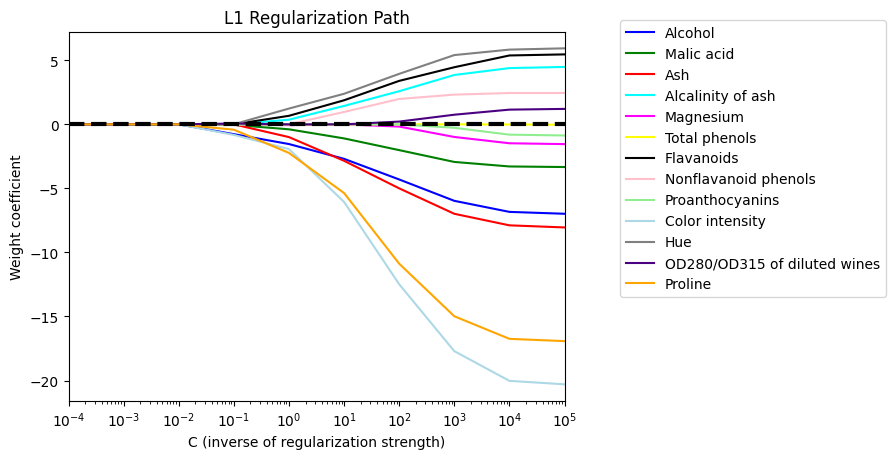

In [124]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red',
          'cyan', 'magenta', 'yellow', 
          'black', 'pink', 'lightgreen',
          'lightblue', 'gray', 'indigo',
          'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = OneVsRestClassifier(LogisticRegression(penalty='l1', 
                        C=10.**c,
                        solver='liblinear',
                        random_state=0))
    lr.fit(X_train_std, y_train)
    weights.append(lr.estimators_[1].coef_[0])
    params.append(10.**c)

weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column+1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**-4, 10**5])
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Weight coefficient')
plt.title('L1 Regularization Path')
plt.legend(loc='upper left')
ax.legend(bbox_to_anchor=(1.38, 1.03), 
          loc='upper center', 
          borderaxespad=0.,
          ncol=1,
          fancybox=True)
plt.show()

In [123]:
df_wine.columns.value_counts().sum()

np.int64(14)

- The resulting plot shows how the weight coefficients for each feature change as the regularization strength varies. As the value of `C` decreases (indicating stronger regularization), more coefficients are driven to zero, resulting in a sparser model. Conversely, as `C` increases (indicating weaker regularization), more coefficients become non-zero, allowing the model to capture more complex relationships in the data. This visualization helps us understand the trade-off between model complexity and sparsity, and it can guide us in selecting an appropriate value for the regularization parameter `C` based on our desired level of feature selection and model interpretability.

## Sequential feature selection algorithms

An alternative approach to reduce the complexity of the model and avoid overfitting is `dimensionality reduction` via `feature selection`. The goal of feature selection is to identify and retain only the most relevant features from the original dataset, thereby reducing the dimensionality of the data while preserving its predictive power. By selecting a subset of meaningful features, we can improve the model's performance, reduce overfitting, and enhance interpretability.

There are two main categories of dimensionality reduction techniques: `feature selection` and `feature extraction`. Feature selection involves selecting a subset of the original features based on their relevance to the target variable, while feature extraction involves transforming the original features into a new set of features that capture the underlying structure of the data.

- `Sequential Feature Selection (SFS)` is a greedy algorithm that iteratively selects features based on their contribution to the model's performance. The algorithm starts with an empty set of selected features and adds one feature at a time, evaluating the model's performance after each addition. The feature that results in the best improvement in performance is retained, and the process continues until a specified number of features is selected or no further improvement can be achieved.

- A classic sequential feature selection algorithm is `Sequential Forward Selection (SFS)`, which starts with an empty set of features and adds one feature at a time based on its contribution to the model's performance. The algorithm evaluates the performance of the model using a specified metric (e.g., accuracy, F1 score) and selects the feature that results in the best improvement in performance. This process continues until a predefined number of features is selected or no further improvement can be achieved.

- Another variant of sequential feature selection is `Sequential Backward Selection (SBS)`, which starts with the full set of features and iteratively removes one feature at a time. The algorithm evaluates the performance of the model after removing each feature and retains the feature that results in the least decrease in performance. This process continues until a predefined number of features is reached or no further improvement can be achieved.

- Greedy Search algorithms like ``SFS` and `SBS` are computationally efficient and can be effective for feature selection in many scenarios. However, they may not always find the optimal subset of features, as they make decisions based on local improvements rather than considering the global feature space. Therefore, it is important to evaluate the performance of the selected features using cross-validation or other validation techniques to ensure that they generalize well to unseen data.

- The idea behind the `SBS` algorithm is to start with the full set of features and iteratively remove one feature at a time. The algorithm evaluates the performance of the model after removing each feature and retains the feature that results in the least decrease in performance. This process continues until a predefined number of features is reached or no further improvement can be achieved. To determine which feature is to be removed at each stage, we need to define the criterion function `J`, that we want optimize.

- The criterion function `J` can be defined based on the specific requirements of the problem at hand. Common choices for `J` include metrics such as accuracy, precision, recall, F1 score, or mean squared error, depending on whether the task is classification or regression. The goal of the SBS algorithm is to minimize (or maximize) the chosen criterion function by removing features that contribute the least to the model's performance.

- The criterion calculated by the criterion function can simply be the difference in the performance of the model before and after removing a feature. For example, if we are using accuracy as the criterion function, we can calculate the accuracy of the model with all features and then calculate the accuracy after removing each feature. The feature that results in the smallest decrease in accuracy is then removed from the feature set.

- We can outline the steps of the SBS algorithm as follows:
  - 1. Initialize the algorithm with `k = d`, where `d` is the dimensionality of the full feature space, $X_{d}$.
  - 2. Determine the feature, $x^{-}$, that maximizes the criterion: $x^{-} = argmaxJ(X_{k} - x)$, where $x \in X_{k}$
  - 3. Remove the feature, $x^{-}$, from the feature set: $X_{k-1} = X_{k} - x^{-}; k = k - 1$
  - 4. Terminate if $k$ equals the number of desired features; otherwise, go to step 2.

In [138]:
X_train.shape[1]

13

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, estimator, k_features: int,
                 scoring=accuracy_score,
                 test_size=0.25, random_state:int=1,
                 ):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self
    
    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In the preceeding implementation, we defined the `k_features` parameter to specify the desired number of features we want to return. By default, we use `accuracy_score` from scikit-learn to evaluate the performance of a model (an estimator for classification) on the feature subsets.


Inside the while loop of the fit method, the feature subsets created by the `itertools.combination` function are evaluated and reduced until the feature subset has the desired dimensionality. In each iteration, the accuracy score of the best subset is collected in a list, `self.scores_`, based on the internally created test dataset, `X_test`. We will use those scores later to evaluate the results. The column indices of the final feature subset are assigned to `self.indices_`, which we can use via the transform method to return a new data array with the selected feature columns. Note that, instead of calculating the criterion explicitly inside the fit method, we simply removed the feature that is not contained in the best performing feature subset.

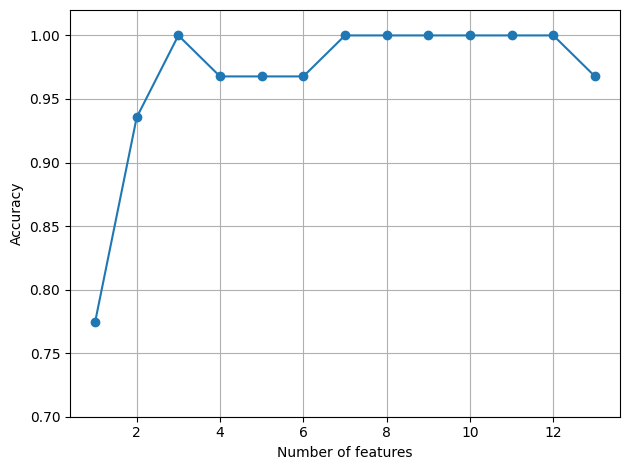

In [139]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/04_09.png', dpi=300)
plt.show()

- Although our `SBS` implementation already splits the dataset into a test and training dataset inside the `fit` function, we still fed the training dataset, `X_train`, to the algorithm. The SBS `fit` method will then create new training subsets for testing (validation) and training, which is why this test set is also called the `validation dataset`. This approach is necessary to prevent our `original test set` from becoming part of the training data.

- Also our `SBS` algorithm collects the scores of the best feature subset at each stage. 

- As we can see in the plot above, the accuracy of the `KNN` classifier improved on the validation dataset as we reduced the number of features, which is likely due to a decrease in the `curse of dimensionality`. We can also see in the plot above that the classifier achieved `100` percent accuracy for `k = {3, 7, 8, 9, 10, 11, 12}`

- To satisfy our own curiosity, let’s see what the smallest feature subset (k=3), which yielded such a good
performance on the validation dataset, looks like:

In [140]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [141]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [149]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


**Feature selection algorithms in scikit-learn**

You can find implementations of several different flavors of sequential feature selection related to the simple SBS [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)

## Assessing feature importance with random forests

In previous sections, you learned how to use `L1` regularization to zero out irrelevant features via `logistic regression` and how to use the `SBS` algorithm for feature selection and apply it to a `KNN algorithm`. Another useful approach for selecting relevant features from a dataset is using a `random forest`, an ensemble technique. Using a random forest, we can measure the feature
importance as the averaged impurity decrease computed from all decision trees in the forest, without making any assumptions about whether our data is linearly separable or not. Conveniently, the random forest implementation in scikit-learn already collects the feature importance values for us so that we can access them via the `feature_importances_` attribute after fitting a `RandomForestClassifier`. By executing the following code, we will now train a forest of `500 trees` on the Wine dataset and rank the `13 features` by their respective importance measures, remember that we don’t need to use standardized or normalized features in tree-based models:

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


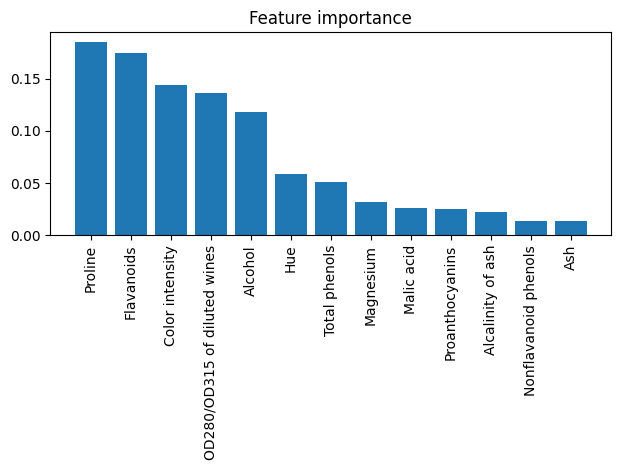

In [150]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

We can conclude that the 

- `proline` and 
- `flavonoid levels`, the 
- `color intensity`, the 
- `OD280/OD315 diffraction`, and the 
- `alcohol` concentration of wine are the most discriminative features in the dataset based on the average impurity decrease in the 500 decision trees. Interestingly, two of the top-ranked features in the plot are also in the three-feature subset selection from the SBS algorithm that we implemented in the previous section (alcohol concentration and OD280/OD315 of diluted wines).

However, as far as interpretability is concerned, the random forest technique comes with an important gotcha that is worth mentioning. If two or more features are highly correlated, one feature may be ranked very highly while the information on the other feature(s) may not be fully captured. On the other hand, we don’t need to be concerned about this problem if we are merely interested in the predictive performance of a model rather than the interpretation of feature importance values.

To conclude this section about `feature importance` values and random forests, it is worth mentioning that scikit-learn also implements a `SelectFromModel` object that selects features based on a user-specified threshold after model fitting, which is useful if we want to use the `RandomForestClassifier` as a feature selector and intermediate step in a scikit-learn Pipeline object, which allows us to connect different preprocessing steps with an estimator. 

For example, we could set the threshold to `0.1` to reduce the dataset to the five most important features using the following code:

In [151]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of features that meet this threshold criterion: 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
